<img src="http://drive.google.com/uc?export=view&id=1tpOCamr9aWz817atPnyXus8w5gJ3mIts" width=500px>

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

#  Top-n list of restaurants on consumer preference

### INDUSTRY CASE STUDY - Popularity based + Collborative Filtering Based Recommendation system
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Case study problem statement:

### Context:

The dataset was obtained from a recommender system prototype. The task was to generate a top-n list of restaurants according to 
the consumer preferences.


### Input data details : https://archive.ics.uci.edu/ml/machine-learning-databases/00232/

(In here you will find rating_final.csv inside RCdata folder to be used)

### Expected output details: Restaurant recommendation system

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

### Steps

#### 1. Input libraries

#### 2. Data Analysis and preparation

#### 3. Popularity based Recommendation System

#### 4. Collaborative Filtering Recommendation System

#### 5. Insights

#### 6. Optional

### 1. Input libraries

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#!pip install surprise

In [1]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

from surprise import Dataset 
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,classification_report

## 2. Data Analysis and preparation

### 2.1 Read the dataset and check info to understand the dataset

In [2]:
df = pd.read_csv("restaurant+rating_final.csv")
df.shape

(1161, 5)

### 2.2 Check statistical summary and write your observations

In [3]:
df.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [4]:
df.describe()

,placeID,rating,food_rating,service_rating
count,1161.000000,1161.000000,1161.000000,1161.000000
mean,134192.041344,1.199828,1.215332,1.090439
std,1100.916275,0.773282,0.792294,0.790844
min,132560.000000,0.000000,0.000000,0.000000
25%,132856.000000,1.000000,1.000000,0.000000
50%,135030.000000,1.000000,1.000000,1.000000
75%,135059.000000,2.000000,2.000000,2.000000
max,135109.000000,2.000000,2.000000,2.000000


- We have 1161 values with 5 columns.
- For placeID, we are not able to understand more here as it is a unique number column and we are not able to deduce how many unique entries are there.
- For Rating, we can see that minimum rating provided is 0 and maximum goes till 2 with mean of 1.19 and standard deviation of 0.77.
- For Food_rating, we have same minimum-maximum range as of rating, but mean is slightly good at 1.21 and standard deviation at 0.79.
- For service_rating, same min-max range as rating and food_rating, but mean is less than both at 1.09 and standard deviation quite similar like food_rating at 0.79.

### 2.3 Check if there are any missing values

In [5]:
df.isnull().sum()

userID            0
placeID           0
rating            0
food_rating       0
service_rating    0
dtype: int64

#### There is no missing value in any column.

### 2.4 Check minimum and maximum values for rating feature. Display its frequency distribution using appropriate graph

Minimum Value in Ratings :  0

Maximum Value in Ratings :  2

Ratings Frequency

2    486
1    421
0    254
Name: rating, dtype: int64


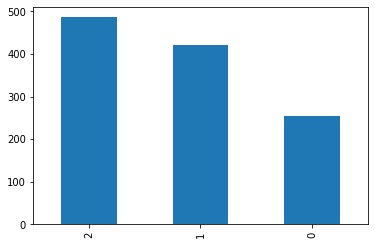

In [6]:
print('Minimum Value in Ratings : ',min(df['rating']))
print('\nMaximum Value in Ratings : ',max(df['rating']))
df['rating'].value_counts().plot(kind = 'bar')
print("\nRatings Frequency\n")
print(df['rating'].value_counts())

- As we can see there are more people who have provided ratings as 2 and less who provided 1 and more less who provided 0.
- Lets see what percentage of popluation provides what rating.

<AxesSubplot:ylabel='rating'>

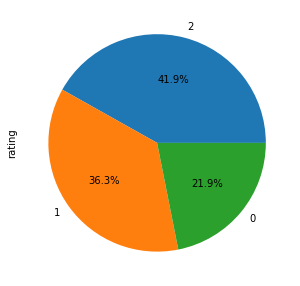

In [7]:
df['rating'].value_counts().plot(kind = 'pie', autopct ='%0.1f%%' , figsize =(15,5))

- So now it is quite clear that, majority of population(41.9%) provide ratings as 2.
- 36.3% of population provided ratings as 1.
- 21.9% of population provided ratings as 0.

### 2.5 Check number of unique users and items (places) in the data

In [8]:
print('Unique Users in our Dataset : ',df['userID'].nunique())
print('\nUnique Items in our Dataset : ',df['placeID'].nunique())

Unique Users in our Dataset :  138

Unique Items in our Dataset :  130


### 2.6 Sort users by their number of ratings and display top 10 users who have given most number of ratings

In [9]:
df.groupby("userID")["rating"].count().sort_values(ascending=False).head(10)

userID
U1061    18
U1106    18
U1134    16
U1024    15
U1022    14
U1089    14
U1137    14
U1135    14
U1003    13
U1016    13
Name: rating, dtype: int64

- There are 2 users who have rated 18 places and that is the summit limit in our dataset.
- Just for information gain, we will also see least ratings given by a single user.

In [10]:
df.groupby("userID")["rating"].count().sort_values(ascending=True).head(10)

userID
U1138    3
U1074    3
U1047    3
U1039    3
U1031    3
U1107    3
U1021    3
U1017    3
U1011    3
U1070    3
Name: rating, dtype: int64

- So we can see there are many users who have rated 3 places and also this is the least ratings provided by any unique user.

### 2.7. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 5 or more number of ratings). Report shape of the final dataset

In [11]:
counts = df['userID'].value_counts()
counts.head()

U1106    18
U1061    18
U1134    16
U1024    15
U1089    14
Name: userID, dtype: int64

In [12]:
df_final = df[df['userID'].isin(counts[counts>=5].index)]
df_final.shape

(1079, 5)

- Now after selecting users which have provided ratings for 5 unique places and more, we are left with only 1079 records.
- 82 records are of users who have provided ratings for less than 5 places.

### 2.8 Check number os unique users and items and comment on which kind of collaborative filtering should be applied

In [13]:
print('Unique Users in our Dataset : ',df_final['userID'].nunique())
print('\nUnique Items in our Dataset : ',df_final['placeID'].nunique())

Unique Users in our Dataset :  115

Unique Items in our Dataset :  129


In [14]:
df_final.sample(5)

,userID,placeID,rating,food_rating,service_rating
185,U1053,132825,1,2,0
1115,U1050,132732,0,1,1
311,U1018,135066,1,1,1
709,U1032,135060,1,1,1
919,U1046,135044,1,1,0


## 3. Popularity Recommender model. (Non-personalised)

### 3.1 Check count of user_id for each unique product and save it as score 

In [15]:
data = df_final.groupby('placeID').agg({'userID':'count'}).reset_index()
data.rename(columns = {'userID':'score'}, inplace = True)
data.head(5)

,placeID,score
0,132560,4
1,132561,2
2,132564,1
3,132572,15
4,132583,4


### 3.2 Sort the products based on the score (calculated above)

In [16]:
data.sort_values(['score','placeID'], ascending= False)

,placeID,score
122,135085,36
30,132825,32
79,135032,28
97,135052,25
32,132834,25
...,...,...
1,132561,2
58,134975,1
19,132715,1
17,132668,1


In [17]:
df_final.groupby('placeID')['rating'].mean().sort_values(ascending = False).head(10)

placeID
132955    2.000000
134986    2.000000
135034    2.000000
134976    2.000000
132922    1.800000
132755    1.800000
135074    1.750000
135055    1.714286
135075    1.692308
134996    1.666667
Name: rating, dtype: float64

### 3.3 Create a new column called 'Rank' having the ascending recommendation rank based upon score 

In [18]:
data_sorted = data.sort_values(['score','placeID'], ascending = False)
data_sorted['Rank'] = data_sorted['score'].rank(ascending = 0, method ='dense')

### 3.4 Get the top 10 recommendation based on their rank

In [19]:
data_sorted.head(14)

,placeID,score,Rank
122,135085,36,1.0
30,132825,32,2.0
79,135032,28,3.0
97,135052,25,4.0
32,132834,25,4.0
83,135038,24,5.0
104,135060,22,6.0
105,135062,21,7.0
87,135042,20,8.0
102,135058,18,9.0


## 4. Collaborative Filtering model

### 4.1 Define rating scale and convert dataframe into surprise dataset

In [20]:
from surprise import Dataset,Reader
reader = Reader(rating_scale=(0,2))
data = Dataset.load_from_df(df_final[['userID', 'placeID', 'rating']], reader)
data

### 4.2 Split the above surprise dataset into train and test set using surprise split function

In [21]:
from surprise.model_selection import train_test_split
trainset,testset = train_test_split(data, test_size=0.25, random_state=29)

In [22]:
userID = []
placeID = []
ratings = []

for (uid, iid, rating) in trainset.all_ratings():
    userID.append(trainset.to_raw_uid(uid))
    placeID.append(trainset.to_raw_iid(iid))
    ratings.append(rating)
dict = {'userId': userID, 'placeId': placeID, 'rating': ratings}
training_df = pd.DataFrame(dict)

### 4.3 Print size of train and test set

In [23]:
trainset.n_ratings

809

In [24]:
len(testset)

270

### 4.4 Build a default SVd model using train set

In [25]:
from surprise import SVD

svd_model = SVD(random_state=29)
svd_model.fit(trainset)

### 4.5 Make prediction for test set and convert test prediction into a dataframe

In [26]:
train_pred = svd_model.test(trainset.build_testset())
pred = svd_model.test(testset)
pred

[Prediction(uid='U1081', iid=135028, r_ui=1.0, est=1.0756016261504948, details={'was_impossible': False}),
 Prediction(uid='U1003', iid=135075, r_ui=2.0, est=1.2460826670126506, details={'was_impossible': False}),
 Prediction(uid='U1053', iid=135053, r_ui=2.0, est=1.2868658500206123, details={'was_impossible': False}),
 Prediction(uid='U1057', iid=135064, r_ui=1.0, est=0.7989576685344927, details={'was_impossible': False}),
 Prediction(uid='U1136', iid=135064, r_ui=1.0, est=1.1619426257157948, details={'was_impossible': False}),
 Prediction(uid='U1009', iid=135079, r_ui=1.0, est=1.1832622279805436, details={'was_impossible': False}),
 Prediction(uid='U1132', iid=135062, r_ui=2.0, est=1.2592227733120094, details={'was_impossible': False}),
 Prediction(uid='U1003', iid=132922, r_ui=2.0, est=1.401305949249322, details={'was_impossible': False}),
 Prediction(uid='U1088', iid=135057, r_ui=1.0, est=1.3263394670387079, details={'was_impossible': False}),
 Prediction(uid='U1029', iid=132937, r

### 4.6 Check RMSe and MAE of train and test predictions

In [27]:
print('Train Set RMSE ',accuracy.rmse(train_pred))

RMSE: 0.4791
Train Set RMSE  0.47912618517857847


In [28]:
print('Train Set MAE ',accuracy.mae(train_pred))

MAE:  0.4013
Train Set MAE  0.4013376201621065


In [29]:
print('Test Set RMSE ',accuracy.rmse(pred))

RMSE: 0.6443
Test Set RMSE  0.6442643423613291


In [30]:
print('Test Set MAE ',accuracy.mae(pred))

MAE:  0.5534
Test Set MAE  0.5534030014962272


In [31]:
pred_df = pd.DataFrame(pred)
pred_df.sample(5)

,uid,iid,r_ui,est,details
262,U1133,134975,1.0,1.184478,{'was_impossible': False}
16,U1115,135108,1.0,1.423819,{'was_impossible': False}
17,U1106,135032,0.0,1.300253,{'was_impossible': False}
99,U1117,135016,2.0,1.036796,{'was_impossible': False}
198,U1059,132825,2.0,1.429934,{'was_impossible': False}


### 4.7 Write a function to make top n recommendation to a user. The function should take a userID, data, and n as input arguments

In [32]:
from collections import defaultdict

In [33]:
def get_top_n(predictions, userid, n):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n[userid]

### 4.8 Check top 3 recommendations for userID:- 'U1028'

In [34]:
get_top_n(pred, 'U1028', 3)

[(132663, 1.1171449332511856), (132613, 0.9813789670296829)]

## 5. Summarize your insights

- We can see that Root Mean Square error for train set is somehow low, but for test set it is considerable.
- For Mean Absolute Error, Train set is giving low value but again error in test set is high and can effect results.
- As we have less data points, we can come to a conclusion that it can be due to data scarcity.
- Also the predictions made by our model are also not that much accurate but can be used for some implications.
- While providing recommendations, our model is not accurate also the result provided have part-errors which is effecting our result.

## Optional
### Use GridSearch CV to get the best parameters for SVD model

In [35]:
param = {'n_factors': list(range(50,200,20))}
Tuners= GridSearchCV(SVD, param, measures=['rmse'], cv = 3)
Tuners.fit(data)

In [36]:
Tuners.best_params['rmse']

{'n_factors': 50}

In [37]:
Tuners.best_score['rmse']

0.66239255402325